In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

Чаще всего работают либо с изображениями в формате `np.uint8` — тогда пиксели принимают значения от 0 до 255, либо в формате с плавающей точкой — тогда значения пикселей лежат в интервале от 0 до 1. Мы сейчас будем использовать второй вариант, потому что так будет удобнее.

In [2]:
def read_gray(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = (img / 255.0).astype(np.float32)
    return img


def show_gray(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=1.0)

# 1. Уголки

Зададим размер окна для уголков.

In [3]:
CORNER_SIZE = (7, 7)

Считаем изображение шахматной доски (далее в тексте $I$).

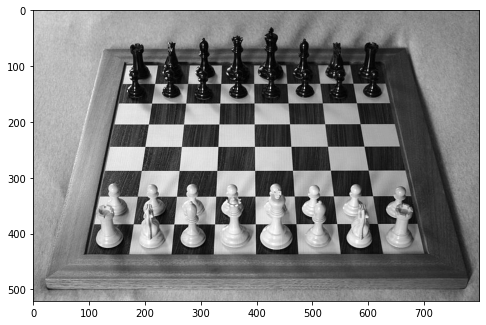

In [4]:
img = read_gray('./chess.jpg')
show_gray(img)

Определим функцию для рисования ключевых точек на изображении.

In [5]:
def draw_corners(img, corners, radius=3, color=(0, 1, 0),
                 y_first=True):
    if len(img.shape) == 2:
        rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif len(img.shape) == 3:
        rgb = img.copy()
    else:
        raise ValueError('Illegal image format')
    for pt in corners:
        if y_first:
            pt_tuple = tuple(pt[::-1])
        else:
            pt_tuple = tuple(pt)
        cv2.circle(rgb, pt_tuple, radius, color)
    return rgb

## 1.1. Подсчет матрицы качества уголков

Для каждого пикселя изображения будем считать минимальное собственное число матрицы
$$
    \sum_{p \in W}{w(p) \begin{pmatrix}
        I_x'(p)^2       & I_x'(p) I_y'(p) \\
        I_x'(p) I_y'(p) & I_y'(p)^2
    \end{pmatrix}}
$$
где
* $I$ — изображение,
* $W$ — множество координат точек окна размера `CORNER_SIZE` с центром в текущем пикселе,
* $w(p)$ — весовая функция.

Сделать это нужно с помощью поэлементных операций из NumPy и сверток из OpenCV, пользоваться циклами (и рекурсией) нельзя.

Посчитайте $I'_x$ — матрицу частных производных по $x$ для каждого пикселя. Используйте для этого `cv2.Sobel`.

In [6]:
# TODO

Аналогичным образом посчитайте $I'_y$.

In [7]:
# TODO

Посчитайте $I'^2_x$ — возведите каждый элемент матрицы в квадрат. Аналогично посчитайте $I'^2_y$. Выведите полученные матрицы с помощью `plt.imshow`.

In [8]:
# TODO

Посчитайте также $I'_x \cdot I'_y$ с помощью попиксельного перемножения матриц $I'_x$ и $I'_y$. Отобразите полученную матрицу с помощью `plt.imshow` (используйте `cmap='seismic'`, чтобы было удобнее различать положительные и отрицательные значения).

In [9]:
# TODO

Мы получили матрицы $I'^2_x$, $I'^2_y$ и $I'_x I'_y$. Теперь нужно обработать их одинаковым образом и посчитать матрицы взвешенных сумм для каждого пикселя в его окрестности размера `CORNER_SIZE`. Иначе говоря, нужно применить к ним размытие. Используйте для этого `cv2.GaussianBlur`. Выведите полученные матрицы, сравните изображения с предыдущими.

In [10]:
# TODO

Для каждого пикселя постройте матрицу $2 \times 2$ из этих взвешенных сумм (структурный тензор). Для этого сначала с помощью `np.dstack` постройте массив размерности `(H, W, 4)`, а затем с помощью `np.ndarray.reshape` поменяйте его размерность на `(H, W, 2, 2)`.

In [11]:
# TODO

Посчитайте собственные значения матриц с помощью `np.linalg.eigvals` (его можно применить к большому массиву из предыдущего шага напрямую).

In [12]:
# TODO

 Выберете минимальные собственные числа с помощью метода `np.ndarray.min`. Получить вещественную часть комплексного числа можно с помощью `np.ndarray.real`. В итоге должен получиться искомый массив качества уголков размера `(H, W)`.

In [13]:
# TODO

Отобразите уголковости с помощью `plt.imshow` и убедитесь, что результат выглядит ожидаемо.

In [14]:
# TODO

## 1.2. Non-Maximum Suppression

Реализуйте функцию `apply_nms`. Она должна оставлять значение пикселя неизменным в случае, когда он больше всех своих соседей в некотором радиусе (можно использовать манхэттенское расстояние), а иначе обращать его в ноль. Не нужно менять входной массив — возвращайте копию.

In [15]:
def apply_nms(min_eigvals, radius=1):
    return None  # TODO

Примените `apply_nms` к уже имеющимся уголковостям и посмотрите на результат.

In [16]:
# TODO

Проверьте производительность функции.

In [17]:
# %timeit apply_nms(min_eigvals, 1)

Скорее всего работает она очень медленно, потому что написана с циклами и условиями, чего обычно стоит избегать. Однако для не очень сложных функций, удовлетворяющих некоторым условиям, есть способ ускориться — Numba.

Возьмите матрицу уголковостей и извлеките из нее координаты уголков, соответствующих значениям, большим некоторого порога (подберите сами). Используйте `np.argwhere`. Должен получиться массив размера `(N, 2)`. Нарисуйте уголки, используя функцию `draw_corners` и `plt.imshow`.

In [18]:
# TODO

## 1.3. Пирамиды

Объедините уже написанный вами код в функцию `detect_corners`.

In [19]:
def detect_corners(img, corner_size=7, min_distance=4, threshold=0.05):
    return None  # TODO

Считаем другое изображение.

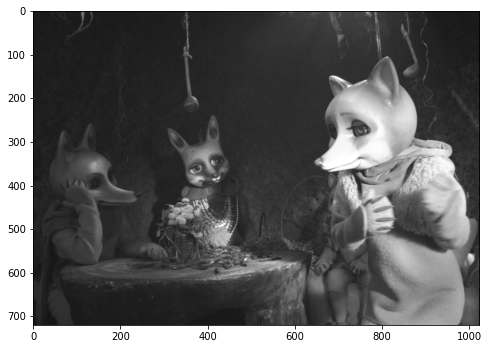

In [20]:
pup = read_gray('./pup.png')
show_gray(pup)

Найдите на трех уровнях пирамиды этого изображения уголки и нарисуйте их на исходном изображении разными цветами и с разными радиусами (соответствующими отмасштабированному размеру окна). Используйте `cv2.pyrDown`.

In [21]:
# TODO

Обратите внимание, что на полученном вами изображении точки с разных уровней пирамиды иногда совпадают. От этого можно избавиться. Давайте будем отдавать приоритет более маленьким уголкам и убирать находящиеся слишком близко к ним уголки большего размера. Реализуйте такую фильтрацию. Используйте рисование масок с помощью `cv2.circle` для проверки близости точек.

In [22]:
# TODO

Более практичным решением кажется приоритизировать уголки по их качеству, а не по размеру. Можете попробовать в домашней!

# 2. Метод Лукаса — Канаде

В данной части будем писать далеко не самую эффективную, зато более-менее простую реализацию метода Лукаса — Канаде для одной особенности.

Считаем изображения.

In [23]:
fox0 = read_gray('./fox_0.png')
fox1 = read_gray('./fox_1.png')

Они кажутся похожими, но на самом деле отличаются.

Зададим позицию пятна под ухом на изображении `fox0`. Нецелую позицию задаем специально, потому что далее нам нужно будет учиться работать с субпиксельной точностью.

In [24]:
pose0 = np.array([116.3, 205.9])

Определим функцию для рисования рамки вокруг отслеживаемой особенности.

In [25]:
def draw_window(img, pose, window_size, color=(0.0, 1.0, 0.0)):
    half_size = window_size // 2
    min_corner = tuple((pose - half_size).round().astype(np.int64))
    max_corner = tuple((pose + half_size).round().astype(np.int64))
    if len(img.shape) == 2:
        rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif len(img.shape) == 3:
        rgb = img.copy()
    else:
        raise ValueError('Illegal image format')
    cv2.rectangle(rgb, min_corner, max_corner, color)
    return rgb

Зададим размер окна.

In [26]:
WINDOW_SIZE = 33

И нарисуем окно на обоих изображениях.

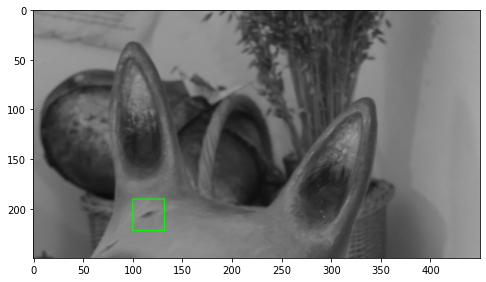

In [27]:
plt.imshow(draw_window(fox0, pose0, WINDOW_SIZE))

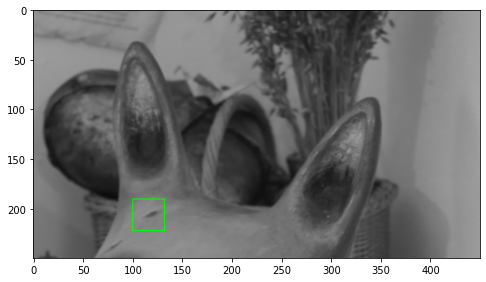

In [28]:
plt.imshow(draw_window(fox1, pose0, WINDOW_SIZE))

Теперь научимся интерполировать изображение и брать значения его точек на сетке размером `WINDOW_SIZE` на `WINDOW_SIZE` с нецелыми координатами точек.

In [29]:
from scipy.interpolate import interp2d

In [30]:
class InterpImg:
    
    def __init__(self, img, window_size=WINDOW_SIZE):
        self.img = img
        
        self._win_xx = np.arange(-window_size // 2, window_size // 2 + 1)
        self._win_yy = np.arange(-window_size // 2, window_size // 2 + 1)

        cols = np.arange(img.shape[1])
        rows = np.arange(img.shape[0])
        self._interp2d = interp2d(cols, rows, img)
        
    def __call__(self, pose):
        return self._interp2d(
            self._win_xx + pose[0],
            self._win_yy + pose[1]
        )

In [31]:
fox0i = InterpImg(fox0)
fox1i = InterpImg(fox1)

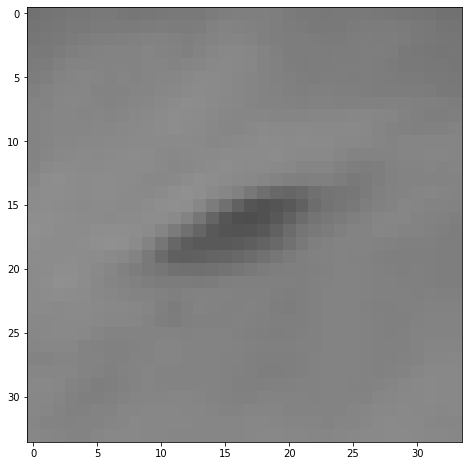

In [32]:
show_gray(fox0i(pose0))

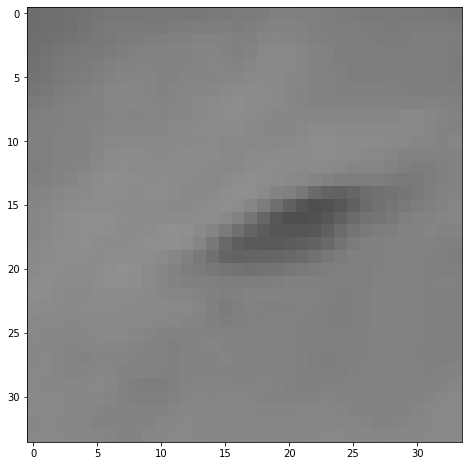

In [33]:
show_gray(fox1i(pose0))

## 2.1. Вектор оптического потока

Посчитайте частные производные `fox1` и сразу оберните их в интерполятор.

In [34]:
# TODO

Посчитайте вектор сдвига позиции пятна, составив и решив переопределенную систему уравнений. Используйте `np.linalg.lstsq`. Обратите внимание на то, что он должен быть направлен в правильную сторону. При этом его длины будет недостаточно для того, чтобы полностью передать правильный сдвиг пятна.

In [35]:
# TODO

Реализуйте итеративный алгоритм подсчета вектора оптического потока. Пользуйтесь заданными ниже константами для задания критерия остановки.

In [36]:
EPS = 1e-2
MAX_ITER = 20

In [37]:
# TODO

Нарисуйте две рамки: исходную и сдвинутую на найденный вектор оптического потока.

In [38]:
# TODO

Выведите квадрат разности между окнами на первом и втором изображениях.

In [39]:
# TODO

## 2.2. Добавляем пирамиды

Оформите написанный выше код в отдельную функцию.

In [40]:
def run_optflow(img0, img1, pose0, pose1_initial=None,
                eps=1e-1, max_iter=10):
    return None  # TODO

Считаем изображение с большим сдвигом пятна.

In [41]:
fox2 = read_gray('./fox_2.png')

Попробуйте запустить `run_optflow` на `fox0` и `fox2`. Сойтись быстро не должно, потому что сдвиг слишком большой. Нужны пирамиды.

In [42]:
# TODO

Реализуйте пирамидальный метод подсчета оптического потока и выведите результат.

In [43]:
# TODO